In [12]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal
from scipy.spatial.distance import cdist
import numpy as np

In [13]:
def shi_tomasi(img, patch_size):
    """ Returns the shi-tomasi scores for an image and patch size patch_size
        The returned scores are of the same shape as the input image """

    sobel_para = np.array([-1, 0, 1])
    sobel_orth = np.array([1, 2, 1])

    Ix = signal.convolve2d(img, sobel_para[None, :], mode="valid")
    Ix = signal.convolve2d(Ix, sobel_orth[:, None], mode="valid").astype(float)

    Iy = signal.convolve2d(img, sobel_para[:, None], mode="valid")
    Iy = signal.convolve2d(Iy, sobel_orth[None, :], mode="valid").astype(float)

    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix*Iy

    patch = np.ones([patch_size, patch_size])
    pr = patch_size // 2
    sIxx = signal.convolve2d(Ixx, patch, mode="valid")
    sIyy = signal.convolve2d(Iyy, patch, mode="valid")
    sIxy = signal.convolve2d(Ixy, patch, mode="valid")

    trace = sIxx + sIyy
    determinant = sIxx * sIyy - sIxy**2

    # the eigen values of a matrix M=[a,b;c,d] are lambda1/2 = (Tr(A)/2 +- ((Tr(A)/2)^2-det(A))^.5
    # The smaller one is the one with the negative sign
    scores = trace/2 - ((trace/2)**2 - determinant)**0.5
    scores[scores < 0] = 0
    scores = np.pad(scores, [(pr+1, pr+1), (pr+1, pr+1)], mode='constant', constant_values=0)
    return scores

def harris(img, patch_size, kappa):
    """ Returns the harris scores for an image given a patch size and a kappa value
        The returned scores are of the same shape as the input image """

    pass
    sobel_para = np.array([-1, 0, 1])
    sobel_orth = np.array([1, 2, 1])

    Ix = signal.convolve2d(img, sobel_para[None, :], mode="valid")
    Ix = signal.convolve2d(Ix, sobel_orth[:, None], mode="valid").astype(float)

    Iy = signal.convolve2d(img, sobel_para[:, None], mode="valid")
    Iy = signal.convolve2d(Iy, sobel_orth[None, :], mode="valid").astype(float)

    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix*Iy

    patch = np.ones([patch_size, patch_size])
    pr = patch_size // 2
    sIxx = signal.convolve2d(Ixx, patch, mode="valid")
    sIyy = signal.convolve2d(Iyy, patch, mode="valid")
    sIxy = signal.convolve2d(Ixy, patch, mode="valid")

    scores = (sIxx * sIyy - sIxy ** 2) - kappa * ((sIxx + sIyy) ** 2)
    scores[scores < 0] = 0
    scores = np.pad(scores, [(pr+1, pr+1), (pr+1, pr+1)], mode='constant', constant_values=0)
    return scores

def selectKeypoints(scores, num, r):
    """
    Selects the num best scores as keypoints and performs non-maximum supression of a (2r + 1)*(2r + 1) box around
    the current maximum.
    """
    keypoints = np.zeros([2, num])
    temp_scores = np.pad(scores, [(r, r), (r, r)], mode='constant', constant_values=0)
    for i in range(num):
        kp = np.unravel_index(temp_scores.argmax(), temp_scores.shape)
        keypoints[:, i] = np.array(kp) - r
        temp_scores[(kp[0] - r):(kp[0] + r + 1), (kp[1] - r):(kp[1] + r + 1)] = 0
    return keypoints

def describeKeypoints(img, keypoints, r):
    """
    Returns a (2r+1)^2xN matrix of image patch vectors based on image img and a 2xN matrix containing the keypoint
    coordinates. r is the patch "radius".
    """
    N = keypoints.shape[1]
    desciptors = np.zeros([(2*r+1)**2, N])
    padded = np.pad(img, [(r, r), (r, r)], mode='constant', constant_values=0)
    for i in range(N):
        kp = keypoints[:, i].astype(int) + r
        desciptors[:, i] = padded[(kp[0] - r):(kp[0] + r + 1), (kp[1] - r):(kp[1] + r + 1)].flatten()
    return desciptors

def matchDescriptors(query_descriptors, database_descriptors, match_lambda):
    """
    Returns a 1xQ matrix where the i-th coefficient is the index of the database descriptor which matches to the
    i-th query descriptor. The descriptor vectors are MxQ and MxD where M is the descriptor dimension and Q and D the
    amount of query and database descriptors respectively. matches(i) will be -1 if there is no database descriptor
    with an SSD < lambda * min(SSD). No elements of matches will be equal except for the -1 elements.
    """
    dists = cdist(query_descriptors.T, database_descriptors.T, 'euclidean')
    matches = np.argmin(dists, axis=1)
    dists = dists[np.arange(matches.shape[0]), matches]
    min_non_zero_dist = dists.min()
    matches[dists >= match_lambda * min_non_zero_dist] = -1
    # remove double matches
    unique_matches = np.ones_like(matches) * -1
    _, unique_match_idxs = np.unique(matches, return_index=True)
    unique_matches[unique_match_idxs] = matches[unique_match_idxs]
    return unique_matches

def plotMatches(matches, query_keypoints, database_keypoints):
    query_indices = np.nonzero(matches >= 0)[0]
    match_indices = matches[query_indices]

    x_from = query_keypoints[0, query_indices]
    x_to = database_keypoints[0, match_indices]
    y_from = query_keypoints[1, query_indices]
    y_to = database_keypoints[1, match_indices]

    for i in range(x_from.shape[0]):
        plt.plot([y_from[i], y_to[i]], [x_from[i], x_to[i]], 'g-', linewidth=3)

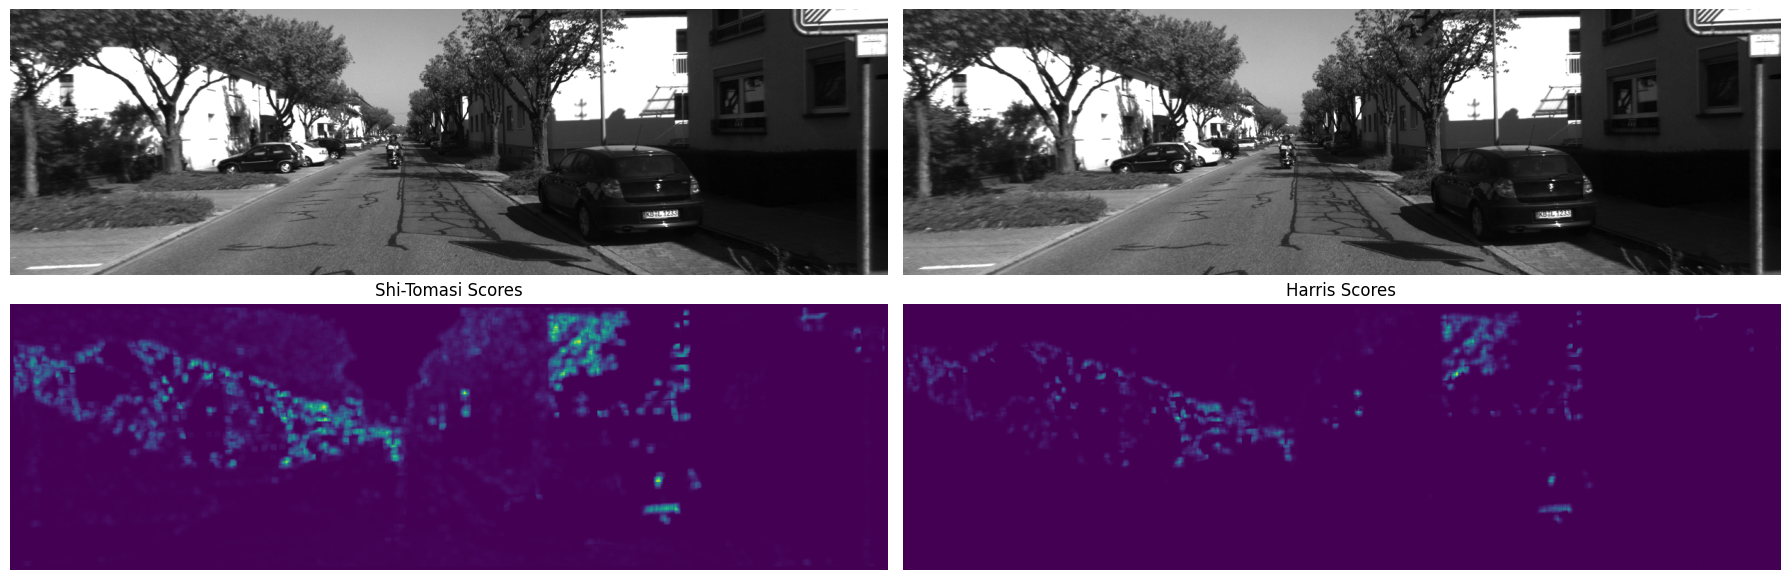

In [14]:
# Randomly chosen parameters that seem to work well - can you find better ones?
corner_patch_size = 9
harris_kappa = 0.08
num_keypoints = 200
nonmaximum_supression_radius = 8
descriptor_radius = 9
match_lambda = 4

img = cv2.imread('./data/000000.png', cv2.IMREAD_GRAYSCALE)

# Part 1 - Calculate Corner Response Functions
# Shi-Tomasi
shi_tomasi_scores = shi_tomasi(img, corner_patch_size)

# Harris
harris_scores = harris(img, corner_patch_size, harris_kappa)
fig, axs = plt.subplots(2, 2, figsize=(18,6))
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 1].imshow(img, cmap='gray')
axs[0, 1].axis('off')

axs[1, 0].imshow(shi_tomasi_scores)
axs[1, 0].set_title('Shi-Tomasi Scores')
axs[1, 0].axis('off')

axs[1, 1].imshow(harris_scores)
axs[1, 1].set_title('Harris Scores')
axs[1, 1].axis('off')

fig.tight_layout()
plt.show()


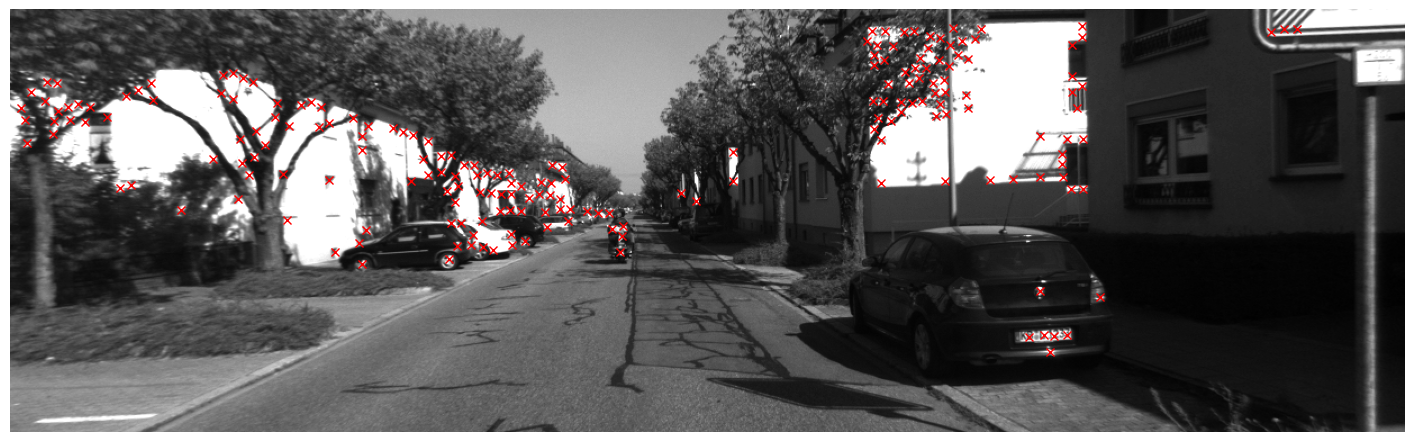

In [15]:
# Part 2 - Select keypoints
keypoints = selectKeypoints(harris_scores, num_keypoints, nonmaximum_supression_radius)

fig = plt.figure(figsize=(18,6))
plt.imshow(img, cmap='gray')
plt.plot(keypoints[1, :], keypoints[0, :], 'rx', linewidth=2)
plt.axis('off')
plt.show()


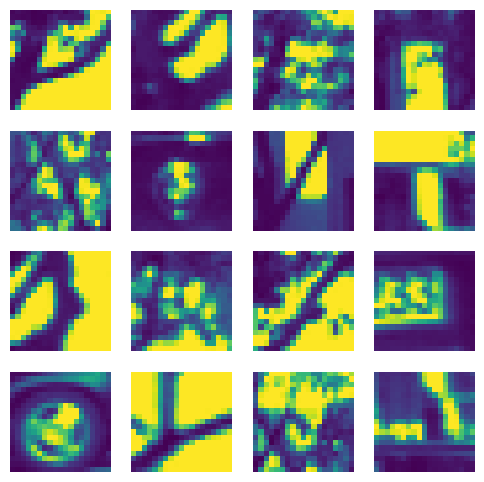

In [18]:
# Part 3 - Describe keypoints and show 16 strongest keypoint descriptors
descriptors = describeKeypoints(img, keypoints, descriptor_radius)

fig, axs = plt.subplots(4, 4, figsize=(6,6))
patch_size = 2 * descriptor_radius + 1
for i in range(16):
    axs[i // 4, i % 4].imshow(descriptors[:, i].reshape([patch_size, patch_size]))
    axs[i // 4, i % 4].axis('off')
plt.show()

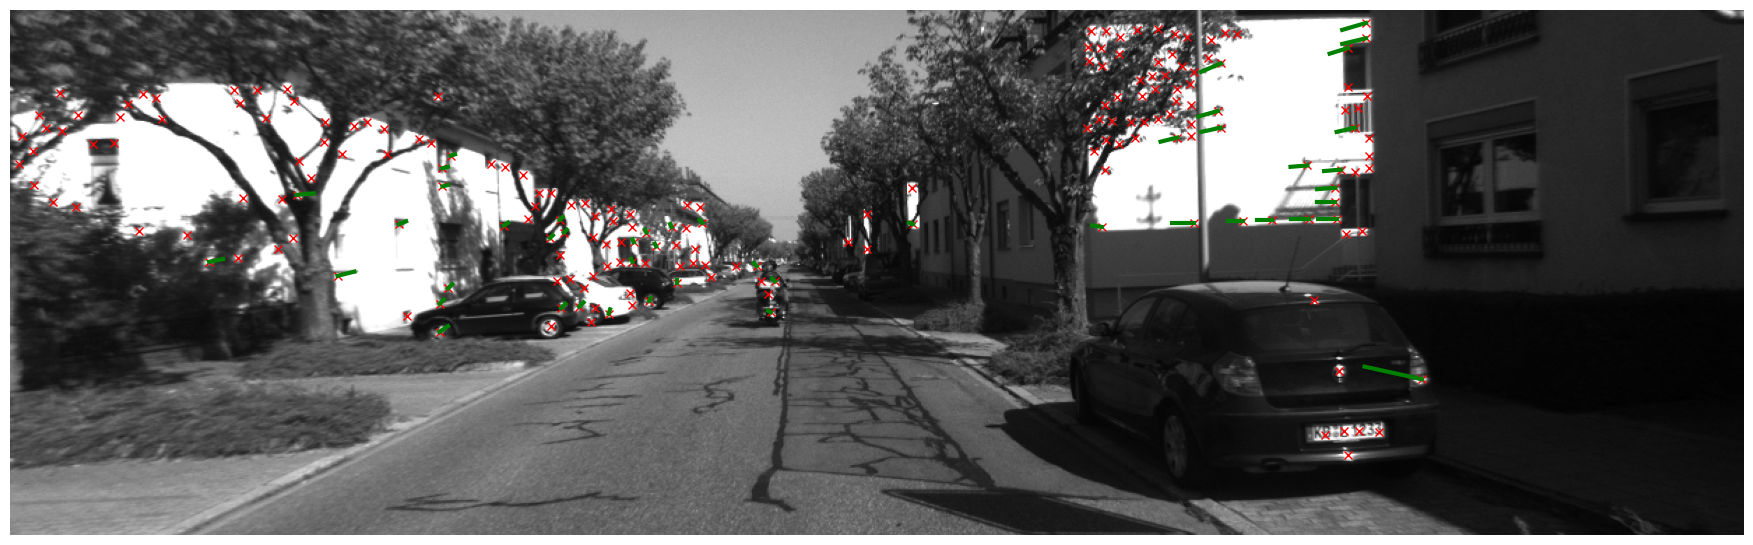

In [20]:
# Part 4 - Match descriptors between first two images
img_2 = cv2.imread('./data/000001.png', cv2.IMREAD_GRAYSCALE)
harris_scores_2 = harris(img_2, corner_patch_size, harris_kappa)
keypoints_2 = selectKeypoints(harris_scores_2, num_keypoints, nonmaximum_supression_radius)
descriptors_2 = describeKeypoints(img_2, keypoints_2, descriptor_radius)

matches = matchDescriptors(descriptors_2, descriptors, match_lambda)

fig = plt.figure(figsize=(18,6))
plt.imshow(img_2, cmap='gray')
plt.plot(keypoints_2[1, :], keypoints_2[0, :], 'rx', linewidth=2)
plotMatches(matches, keypoints_2, keypoints)
plt.tight_layout()
plt.axis('off')
plt.show()


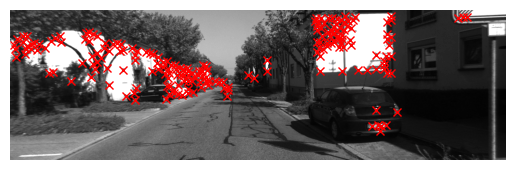

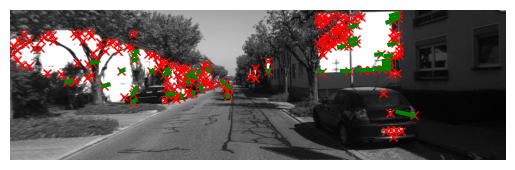

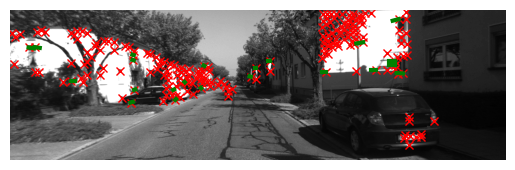

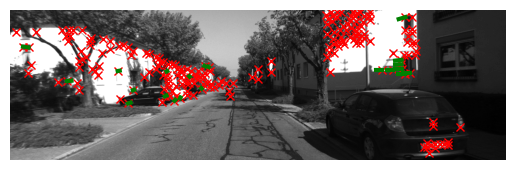

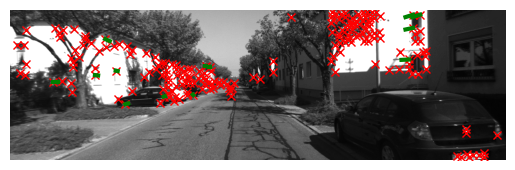

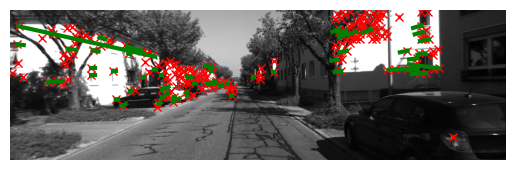

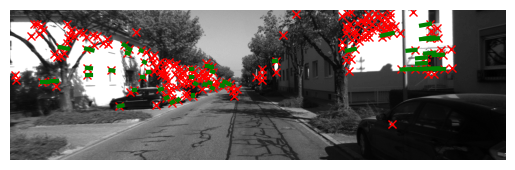

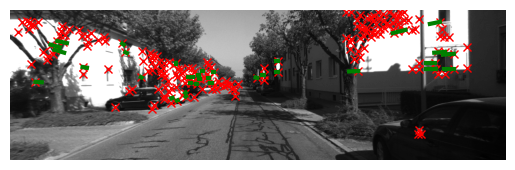

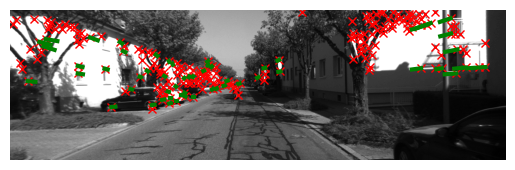

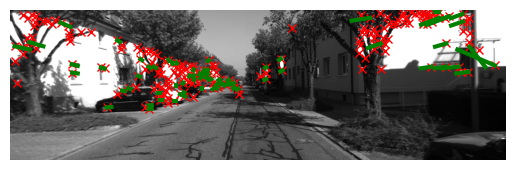

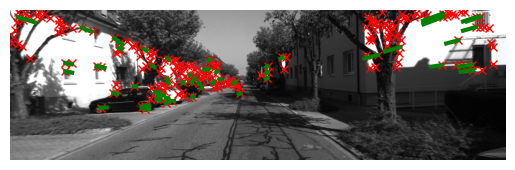

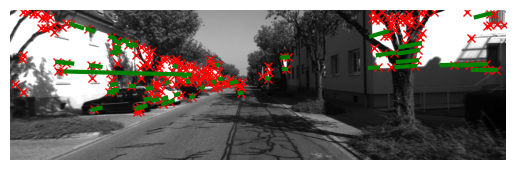

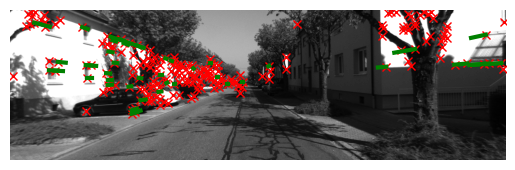

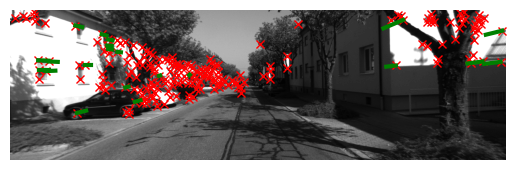

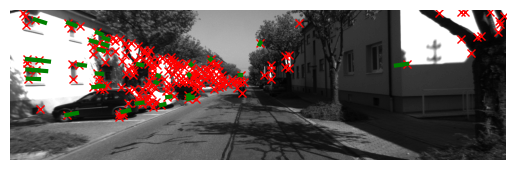

KeyboardInterrupt: 

In [21]:
# Part 5 - Match descriptors between all images
prev_desc = None
prev_kp = None
for i in range(200):
    plt.clf()
    img = cv2.imread('./data/{0:06d}.png'.format(i), cv2.IMREAD_GRAYSCALE)
    scores = harris(img, corner_patch_size, harris_kappa)
    kp = selectKeypoints(scores, num_keypoints, nonmaximum_supression_radius)
    desc = describeKeypoints(img, kp, descriptor_radius)

    plt.imshow(img, cmap='gray')
    plt.plot(kp[1, :], kp[0, :], 'rx', linewidth=2)
    plt.axis('off')

    if prev_desc is not None:
        matches = matchDescriptors(desc, prev_desc, match_lambda)
        plotMatches(matches, kp, prev_kp)
    prev_kp = kp
    prev_desc = desc

    plt.pause(0.1)
